In [23]:
#import packages
import requests
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import hamming_loss
from sklearn.model_selection import cross_validate as cv
from matplotlib import pyplot as plt
import math
from scipy.cluster.hierarchy import dendrogram, linkage

## Multi-class and Multi-Label Classification Using Support Vector Machines

In [6]:
#get hamming_loss
def get_hamming_loss(label, predicted):
    hamm_loss = np.array(label != predicted).sum() / (label.shape[0] * label.shape[1])
    return hamm_loss


In [7]:
#get exact match
def get_exact_match(label, predicted):
    score = 0
    for i in range(label.shape[0]):
        true = label.iloc[i,:]
        pred = predicted.iloc[i,:]
        if(np.array(true == pred).sum() == label.shape[1]):
            score = score + 1
    score = score / label.shape[0]
    return score


In [8]:
# determine majoirty 
def get_count(col):
    df = pd.DataFrame()
    for cluster in sorted(list(frogs_y.clusters.unique())):
        curr_cluster = frogs_y[frogs_y.clusters == cluster]
        curr_dict = {'cluster' : cluster}
        for label in frogs_y[col].unique():
            count = curr_cluster[curr_cluster[col] == label].count()[0]
            curr_dict[label] = count
        df = df.append(curr_dict, ignore_index = True)
    return df


In [9]:
def get_majority(df_count):
    df_majority = pd.DataFrame(columns = ['cluster', 'majority', 'count'])
    df_majority['cluster'] = df_count.cluster
    df_majority['majority'] = df_count.idxmax(axis = 1)
    df_majority['count'] = df_count.max(axis = 1)
    return df_majority

In [19]:
#Download data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip"
content = requests.get(url)
file = ZipFile(BytesIO(content.content))

data_frogs = pd.read_csv(file.open('Frogs_MFCCs.csv'), low_memory = False)
train_frogs = data_frogs.sample(frac = .7, random_state = 78)
train_frogs = train_frogs.reset_index(drop = True)
test_frogs = data_frogs.drop(train_frogs.index)
test_frogs = test_frogs.reset_index(drop = True)

#split train / test
train_frogs_x = train_frogs.iloc[:, :-4]
train_frogs_labels = train_frogs.iloc[:, -4: -1]

test_frogs_x = test_frogs.iloc[:, :-4]
test_frogs_labels = test_frogs.iloc[:, -4: -1]

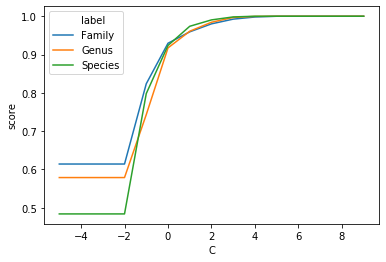

In [42]:
#1.(b)ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers.
c_estimate = pd.DataFrame(columns = ['label', 'C', 'score'])

for label in train_frogs_labels.columns:
    for x in range(-5,10):
        s = SVC(C = 10**x, kernel = 'rbf', decision_function_shape = 'ovr', gamma = 'auto')
        s.fit(train_frogs_x, train_frogs_labels.loc[:,label])
        score_c = s.score(train_frogs_x, train_frogs_labels.loc[:,label])
        c_estimate = c_estimate.append({'label' : label, 'C' : x, 'score' : score_c}, ignore_index = True)

sns.lineplot(x = 'C', y = 'score', hue = 'label', data = c_estimate)
plt.savefig("c_estimate.png")

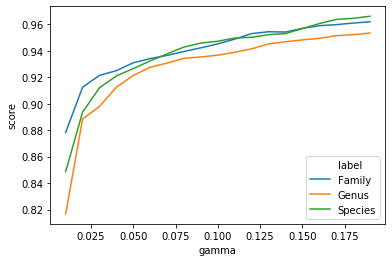

In [45]:
gamma_estimate = pd.DataFrame(columns = ['label', 'gamma', 'score'])
        
for label in train_frogs_labels.columns:
    for g in range(1,20):
        s = SVC(kernel = 'rbf', decision_function_shape = 'ovr', gamma = .01*g)
        s.fit(train_frogs_x, train_frogs_labels.loc[:,label])
        score_g = s.score(train_frogs_x, train_frogs_labels.loc[:,label])
        gamma_estimate = gamma_estimate.append({'label' : label, 'gamma' : .01*g, 'score' : score_g}, ignore_index = True)
        
sns.lineplot(x = 'gamma', y = 'score', hue = 'label', data = gamma_estimate) 
plt.savefig("gamma_estimate.png")

In [12]:
#cross_validation       
parameters = {'C' : [10**x for x in range(-1,4)], 
              'gamma' : [.1*y for y in range(2,21)]}

svc = SVC(kernel = 'rbf', decision_function_shape = 'ovr')
svm = GridSearchCV(svc, parameters, cv = 10)

svm_best_params = pd.DataFrame(columns = ['label', 'params', 'score'])
for label in train_frogs_labels.columns:
    svm.fit(train_frogs_x, train_frogs_labels.loc[:,label])
    best_params = svm.best_params_
    cv_best_score = svm.best_score_
    svm_best_params = svm_best_params.append({'label' : label,
                                              'params' : best_params,
                                              'score' : cv_best_score}, ignore_index = True)

In [20]:
#predict all classes(train) / test
svm_predicted_train = pd.DataFrame()
svm_predicted_test = pd.DataFrame()
for i in range(len(svm_best_params.label)):
    svm = SVC(kernel = 'rbf', decision_function_shape = 'ovr', 
              gamma = svm_best_params.params[i]['gamma'], C = svm_best_params.params[i]['C'])
    svm.fit(train_frogs_x, train_frogs_labels.loc[:,svm_best_params.label[i]])
    svm_predicted_train[svm_best_params.label[i]] = svm.predict(train_frogs_x)
    svm_predicted_test[svm_best_params.label[i]] = svm.predict(test_frogs_x)
    
svm_scores = pd.DataFrame(columns = ['exact_match', 'hamming_score'])
svm_scores = svm_scores.append({'exact_match' : get_exact_match(train_frogs_labels, svm_predicted_train),
                               'hamming_score' : 1 - get_hamming_loss(train_frogs_labels, svm_predicted_train)},
                                ignore_index = True)
svm_scores = svm_scores.append({'exact_match' : get_exact_match(test_frogs_labels, svm_predicted_test),
                               'hamming_score' : 1 - get_hamming_loss(test_frogs_labels, svm_predicted_test)},
                                ignore_index = True)


In [26]:
#l1 penalty svm
best_params_l1 = pd.DataFrame(columns = ['label', 'penalty', 'score'])
for label in train_frogs_labels.columns:
    best_score = 0
    best_x = None
    for x in range(-5, 5):
        svc_lin = LinearSVC(penalty = 'l1', multi_class = 'ovr', dual = False, C = 10**x)
        cv_svc_lin = cv(svc_lin, train_frogs_x, train_frogs_labels.loc[:,label], cv = 10)
        score_l1 = np.mean(cv_svc_lin['test_score'])
        if score_l1 > best_score:
            best_score = score_l1
            best_x = x
    best_params_l1 = best_params_l1.append({'label': label, 'penalty': best_x, 'score': best_score},
                                       ignore_index = True)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [27]:
#l1 penalty svm predict all classes(train) / test
svc_lin_predicted_train = pd.DataFrame()
svc_lin_predicted_test = pd.DataFrame()
for i in range(len(train_frogs_labels.columns)):
    svc_lin = LinearSVC(penalty = 'l1', multi_class = 'ovr', dual = False, max_iter = 10000, C = 10**best_params_l1['penalty'][i])
    svc_lin.fit(train_frogs_x, train_frogs_labels.iloc[:,i])
    svc_lin_predicted_train[train_frogs_labels.columns[i]] = svc_lin.predict(train_frogs_x)
    svc_lin_predicted_test[train_frogs_labels.columns[i]] = svc_lin.predict(test_frogs_x)
    
svc_lin_scores = pd.DataFrame(columns = ['exact_match', 'hamming_score'])
svc_lin_scores = svc_lin_scores.append({'exact_match' : get_exact_match(train_frogs_labels, svc_lin_predicted_train),
                               'hamming_score' : 1 - get_hamming_loss(train_frogs_labels, svc_lin_predicted_train)},
                                ignore_index = True)
svc_lin_scores= svc_lin_scores.append({'exact_match' : get_exact_match(test_frogs_labels, svc_lin_predicted_test),
                               'hamming_score' : 1 - get_hamming_loss(test_frogs_labels, svc_lin_predicted_test)},
                                ignore_index = True)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [29]:
#smote get optimal penalty
l1_penalty_smote = pd.DataFrame(columns = ['label', 'penalty', 'score'])
smote = SMOTE(random_state = 78)
for label in train_frogs_labels.columns:
    train_frogs_x_smote, train_frogs_y_smote = smote.fit_resample(train_frogs_x, train_frogs_labels.loc[:,label])
    best_score = 0
    best_x = None
    for x in range(-5, 5):
        svc_lin = LinearSVC(penalty = 'l1', multi_class = 'ovr', dual = False, C = 10**x)
        cv_svc_smote = cv(svc_lin, train_frogs_x_smote, train_frogs_y_smote, cv = 10)
        score_smote = np.mean(cv_svc_smote['test_score'])
        if score_smote > best_score:
            best_score = score_smote
            best_x = x
    l1_penalty_smote = l1_penalty_smote.append({'label': label, 'penalty': best_x, 'score': best_score},
                                       ignore_index = True)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [47]:
#smote train all classifers / test

exact_match_train = 0
hamming_smote_train = 0

exact_match_test = 0
hamming_smote_test = 0

for i in range(len(train_frogs_labels.columns)):
    smote_predicted_train = pd.DataFrame()
    smote_predicted_test = pd.DataFrame()
    train_smote_labels = pd.DataFrame()
    test_smote_labels = pd.DataFrame()
    
    train_frogs_x_smote, train_frogs_y_smote = smote.fit_resample(train_frogs_x, train_frogs_labels.iloc[:,i])
    test_frogs_x_smote, test_frogs_y_smote = smote.fit_resample(test_frogs_x, test_frogs_labels.iloc[:,i])
    
    train_smote_labels[train_frogs_labels.columns[i]] = train_frogs_y_smote
    test_smote_labels[test_frogs_labels.columns[i]] = test_frogs_y_smote
    
    svc_lin = LinearSVC(penalty = 'l1', multi_class = 'ovr', dual = False, C = 10**best_params_l1['penalty'][i])
    svc_lin.fit(train_frogs_x_smote, train_frogs_y_smote)
    
    smote_predicted_train[train_frogs_labels.columns[i]] = svc_lin.predict(train_frogs_x_smote)
    smote_predicted_test[test_frogs_labels.columns[i]] = svc_lin.predict(test_frogs_x_smote)
    
    exact_match_train = exact_match_train + get_exact_match(train_smote_labels, smote_predicted_train)
    hamming_smote_train = 1 - get_hamming_loss(train_smote_labels, smote_predicted_train)
    
    exact_match_test = exact_match_test + get_exact_match(test_smote_labels, smote_predicted_test)
    hamming_smote_test = 1 - get_hamming_loss(test_smote_labels, smote_predicted_test)

exact_match_train = (exact_match_train / 3)
hamming_smote_train = (hamming_smote_train / 3)

exact_match_test = (exact_match_test / 3)
hamming_smote_test = (hamming_smote_test / 3)

smote_scores = pd.DataFrame(columns = ['exact_match', 'hamming_score'])
smote_scores = smote_scores.append({'exact_match' : exact_match_train, 'hamming_score' : hamming_smote_train}, 
                                   ignore_index = True)
smote_scores = smote_scores.append({'exact_match' : exact_match_test, 'hamming_score' : hamming_smote_test}, 
                                   ignore_index = True)



/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


KeyboardInterrupt: 

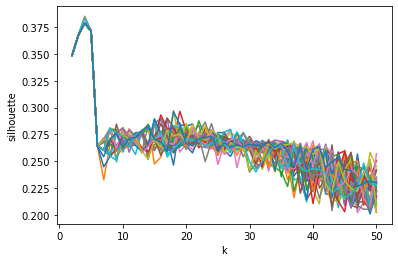

In [48]:
#monte-carlos kmeans

monte_carlo = pd.DataFrame(columns = ['hamming_distance', 'hamming_loss', 'hamming_score'])
for m in range(1, 51):
    
    frogs_cluster = data_frogs.sample(frac = 1)
    frogs_x = frogs_cluster.iloc[:, : -4]
    frogs_y = frogs_cluster.iloc[:,-4 : -1]
    
    best_k = None;
    num_clusters = pd.DataFrame(columns = ['k', 'silhouette'])
    for k in range(2, 51):
        kmeans = KMeans(n_clusters = k)
        clusters = kmeans.fit_predict(frogs_x)
        ss = silhouette_score(frogs_x, clusters)
        num_clusters = num_clusters.append({'k' : k, 'silhouette': ss}, ignore_index = True)
    sns.lineplot(x = 'k', y = 'silhouette', data = num_clusters)
    
    best_k = int(num_clusters.loc[num_clusters['silhouette'].idxmax(),'k'])
    kmeans = KMeans(n_clusters = best_k)
    clusters = kmeans.fit_predict(frogs_x)        
    frogs_y['clusters'] = clusters        

    num_family = get_count('Family')
    num_genus = get_count('Genus')
    num_species = get_count('Species')
                
    maj_family = get_majority(num_family)
    maj_genus = get_majority(num_genus)
    maj_species = get_majority(num_species)            
                
    maj_all = pd.DataFrame()
    maj_all['cluster'] = maj_family.cluster 
    maj_all['Family'] = maj_family.majority 
    maj_all['Genus'] = maj_genus.majority
    maj_all['Species'] = maj_species.majority
    
    frogs_y = frogs_y.sort_index()
    maj_all = maj_all.set_index('cluster')
    
    hamm_loss = 0  
    hamm_dist = 0         
    for i in range(frogs_y.shape[0]):
        true = frogs_y.iloc[i, : -1]
        pred = maj_all.iloc[frogs_y.iloc[i].clusters, :]
        hamm_loss +=  hamming_loss(true, pred)   
        hamm_dist += sum(true != pred)    
    
    hamm_loss = hamm_loss / frogs_y.shape[0]            
    hamm_score = 1 - hamm_loss  
    hamm_dist = hamm_dist / frogs_y.shape[0]          
    
    monte_carlo = monte_carlo.append({'hamming_distance': hamm_dist, 'hamming_loss': hamm_loss, 'hamming_score': hamm_score},
                                     ignore_index = True)
plt.savefig("monte_carlo.png")
    
mc_info = pd.DataFrame(columns = monte_carlo.columns, index = ['average', 'std'])
mc_info.loc['average'] = monte_carlo.mean()
mc_info.loc['std'] = monte_carlo.std()   

# REPORT

### a)
#### i. Research exact match and hamming score/ loss methods for evaluating multi- label classification and use them in evaluating the classifiers in this problem.
    Exact Match:
        The percentage of samples that have all their labels classified correctly.

    Hamming Loss: 
        The fraction of the wrong labels to the total number of labels. 
        The optimal value is 0
	
    Hamming Score: 
             1 - hamming loss
#### ii. SVM using Gaussian kernels
    The optimal parameters for SVM using Gaussian kernels is saved under variable name 'svm_best_params'. These parameters were obtained from 10-fold cross validation. Before performing 10-fold cross validation on both parameters, I ran possible values of C, and gammas respectively, in order to narrow down the scope.
    As shown in the image below, the accuracy improved drastically for C >= 10**-1 for all three labels, and reached 1 when C>=10**4. In order to prevent underfitting and overfitting, I limited the scope of C to: 10**-1 <= C <= 10**4
<img src = "c_estimate.png">

    and the accuracy improved drastically for gamma >= .2 as shown in the image below.
<img src = "gamma_estimate.png">

    The test, and training scores of this model is under variable name 'svm_scores'. 
                    exact_match	         hamming_score
    train        0.999801429706116	  0.9999338099020386
    test         0.9907364520611394	  0.9941330863053883
    
    We can see that the hamming score is slightly higher than the exact match score, and although the score
#### iii. l1 penalized SVMs
    The optimal penalty is stored under variable name 'best_params_l1', which was obtained by 10-fold cross validation.
    The test, and training scores of this model is under variable name 'svc_lin_scores'.

                    exact_match	          hamming_score
    train       0.9209690230341541	   0.9516812284882181
    test        0.8661417322834646	   0.9277443260768874
    

#### iv. SMOTE L1 penalized SVMs
    The optimal penalty is stored under variable name 'l1_penalty_smote', which was obtained by 10-fold cross-validation.
    The test, and training scores of this model is under variable name 'smote_scores'

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set
### a) k-means clustering, choose k∈ {1, 2, . . . , 50} 
    I used silhouette score to determine the optimal k. The optimal ks obtained by Monte-Carlo simulation is shown in the figure below. The optimal k seems to be around 4~6.
<img src = 'monte_carlo.png'>
    
    
### b), c)
    After obtaining the majority labels of each cluster, I calcaulated the hamming loss, hamming score, and average hamming distance for each iteration, and it is saved as variable 'monte_carlo'. The average and standard deviation of those scores are stored in 'mc_info'
                hamming_distance	    hamming_loss	           hamming_score
    average	    0.672575399583044	    0.22419179986101578	    0.7758082001389842
        std	    0.017407093495589967	0.00580236449852983	    0.005802364498529851

    
